In [ ]:
import os

from ray import train, tune
from ray.tune.examples.mnist_pytorch import train_mnist
from ray.tune import ResultGrid

from hydra import initialize, compose

from omegaconf import OmegaConf
from datasets import load_data
from architectures import load_architecture
from utils import load_optimizer, get_args2, set_seeds, Hp_opt

import torch

# initialize(config_path="configs", version_base=None)

from utils import Setup
from distributed_experiment2 import BaseExperiment

world_size = torch.cuda.device_count()

full_path = os.path.abspath("./hpo_results")

project_name = 'test30'

dataset = 'Aircraft'
loss = 'CLASSIC_AT'
backbone = 'convnext_tiny.fb_in22k'
            
config = OmegaConf.load("./configs/default_config.yaml")

config = compose(config_name="default_config")  # Store Hydra config in a variable

config.dataset = dataset
config.backbone = backbone
config.loss_function = loss
config.project_name = 'test30'

set_seeds(config.seed)

print(config)

setup = Setup(config, world_size)
experiment = BaseExperiment(setup)
 
hp_search = Hp_opt(setup)
trainer = hp_search.get_trainer(experiment.training)

tuner = tune.Tuner.restore('{}/0001_deit_small_patch16_224.fb_in1k_Flowers_CLASSIC_AT'.format(full_path, project_name, backbone, dataset, loss), trainable=trainer)

# tuner
result_grid = tuner.get_results()

{'dataset': 'Aircraft', 'backbone': 'convnext_tiny.fb_in22k', 'ft_type': 'full_fine_tuning', 'loss_function': 'CLASSIC_AT', 'seed': 0, 'epochs': 10, 'lr1': None, 'lr2': None, 'weight_decay1': None, 'weight_decay2': None, 'use_rs': False, 'epsilon': 0.015686275, 'step_size': 0.007843137, 'perturb_steps': 10, 'distance': 'Linf', 'beta': 1.0, 'project_name': 'test30'}
serialized_values convnext_tiny.fb_in22k_Aircraft_CLASSIC_AT
1


       loss   timestamp checkpoint_dir_name   done  training_iteration  \
0  5.188013  1734552461                None  False                   1   
1  5.066510  1734552469                None  False                   2   
2  4.822526  1734552478                None  False                   3   
3  4.614681  1734552487                None  False                   4   
4  4.921361  1734552496                None  False                   5   
5  4.557133  1734552504                None  False                   6   
6  5.157651  1734552513                None  False                   7   
7  4.848315  1734552522                None  False                   8   
8  5.106311  1734552531                None  False                   9   
9  4.728516  1734552540                None  False                  10   

      trial_id                 date  time_this_iter_s  time_total_s    pid  \
0  75f3d_00001  2024-12-18_15-07-41         14.509698     14.509698  57378   
1  75f3d_00001  2024-12-18_15

Text(0, 0.5, 'Loss')

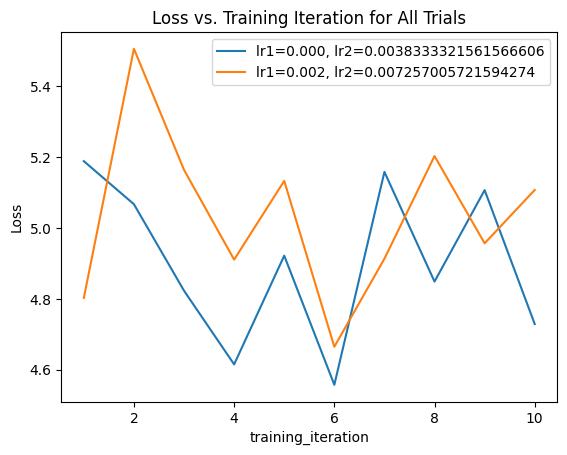

In [ ]:
ax = None
for result in result_grid:
    print(result.metrics_dataframe)
    res = result.config['train_loop_config']
    # print(res)
    print()
    label = f"lr1={res['lr1']:.3f}, lr2={res['lr2']}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "loss", ax=ax, label=label)
        
ax.set_title("Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Loss")